## Car Accident Severity Classification Modeling
This notebook is using data collected and cleaned in the `car_accidents_eda.ipynb` notebook, and will be using that data to create a classification model for predicting the severity of a car accident.

First, import libraries and modules needed >

In [149]:
# First, install imbalanced-learn if needed by un-hashing and running:
# !pip install -U imbalanced-learn

In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

import pickle
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


Now import the dataset created and prepared for modeling >

In [83]:
# now re-open the dataset up again to continue work and analysis on it

with open('pickle/model_data2.pickle','rb') as read_file:
    model_data2 = pickle.load(read_file)

-
#### Split the data into Training, Validation, and Test Sets

In [84]:
X = model_data2.drop(columns='Severity')
y = model_data2['Severity']

In [85]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=.25,
                                                  random_state=42,
                                                  stratify = y_train_val
                                                 )

-
#### Examine each variable's relationship to the target

Starting with pairplots for the numberical variables to the target variable (Severity)

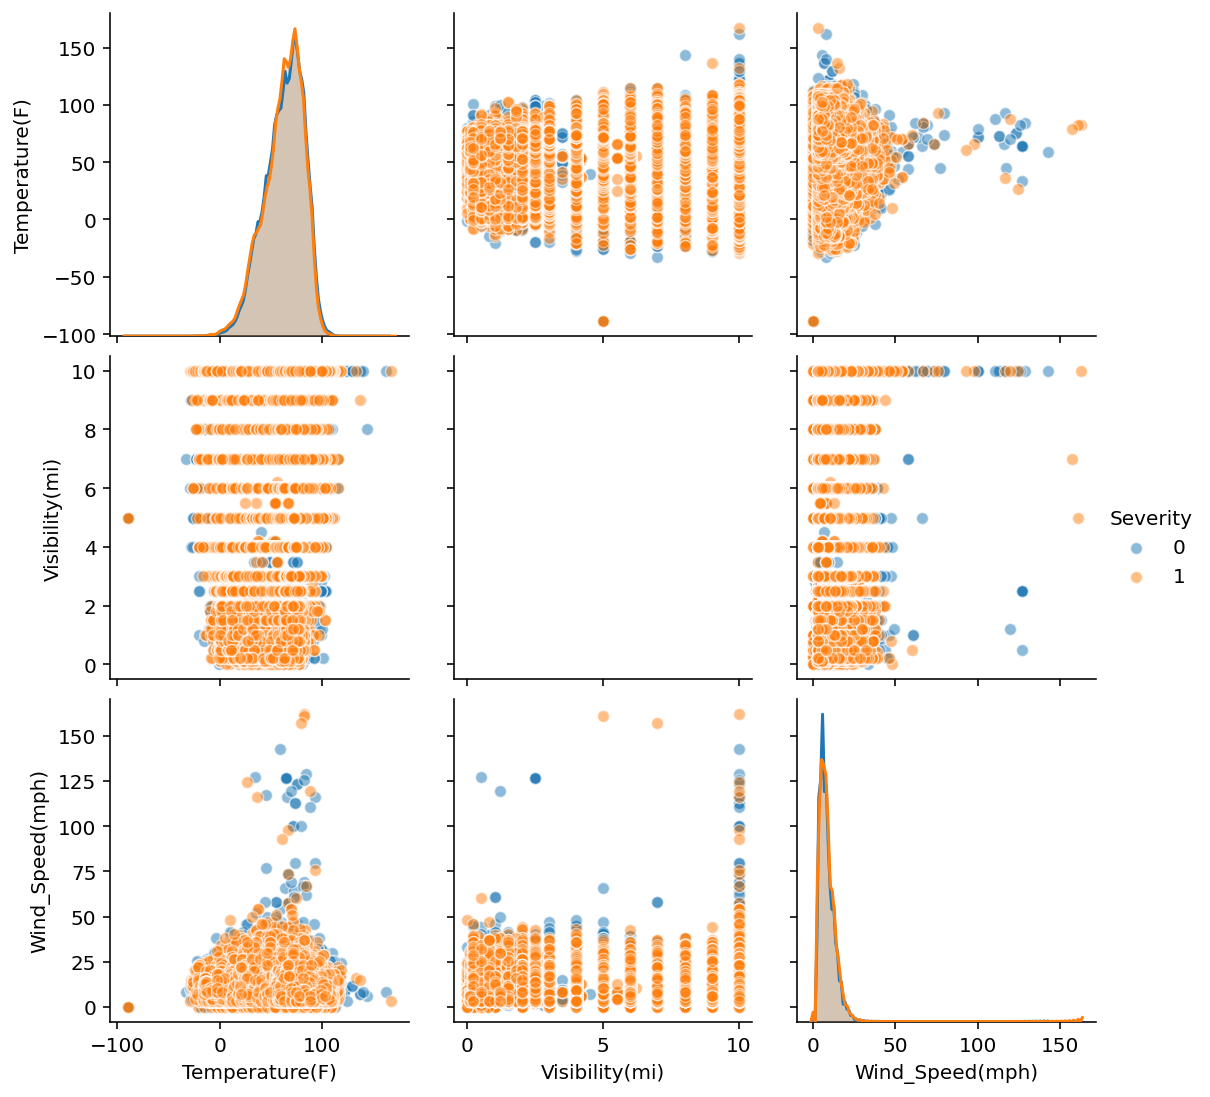

In [8]:
# first look at relationship with variables/features that are numerical

sns.pairplot(model_data2[['Severity','Temperature(F)',
                          'Visibility(mi)','Wind_Speed(mph)']],
             hue='Severity', plot_kws=dict(alpha=.5));

#### Takeaways:
- No strong indiction of relationship between severity and these variables

Before getting into modeling, create a function that will display a visual of the confusion matrix for the models' performances.  We'll then use this function for each model >

## Modeling

### LG1 Model (Logistic Regression)
Before doing more advanced work, let's start with a simple Logistic Regression model and test out various combinations of variables to see what can get best results.  This will give us an indication of direciton to take feature selections >

In [87]:
X_train.columns

Index(['Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station', 'Stop',
       'Traffic_Signal', 'Sunrise_Sunset', 'Year', 'Shut_Down',
       'Weather_Condition_Clear/Fair', 'Weather_Condition_Cloudy',
       'Weather_Condition_Dusty', 'Weather_Condition_Foggy/Hazy',
       'Weather_Condition_Overcast', 'Weather_Condition_Rain/Thunderstorms',
       'Weather_Condition_Smoke', 'Weather_Condition_Snow/Hail',
       'Weather_Condition_Wintry Mix'],
      dtype='object')

In [47]:
std_scale = StandardScaler()

#features we want to use in this model
v1_features = ['Weather_Condition_Rain/Thunderstorms', 'Sunrise_Sunset',
               'Traffic_Signal','Weather_Condition_Snow/Hail',
               'Weather_Condition_Foggy/Hazy','Shut_Down',
               'Crossing','Temperature(F)',
               'Weather_Condition_Clear/Fair',
               'Junction'
              ]

#create new X set of v1 features for training and test set
X_train_v1 = X_train[v1_features]
X_val_v1 = X_val[v1_features]
X_test_v1 = X_test[v1_features]

# scale all of the features for training and test set
X_train_scaled_v1 = std_scale.fit_transform(X_train_v1)
X_val_scaled_v1 = std_scale.fit_transform(X_val_v1)
X_test_scaled_v1 = std_scale.fit_transform(X_test_v1)

# create training model using scaled features
LR1 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v1, y_train)

In [48]:
# create predicted values of LR1 model

pred_train_lr1 = LR1.predict(X_train_scaled_v1)
pred_val_lr1 = LR1.predict(X_val_scaled_v1)
pred_test_lr1 = LR1.predict(X_test_scaled_v1)

# create list of predicted probabilities for LR1 model

predict_prob_lr1 = LR1.predict_proba(X_test_scaled_v1)

In [49]:
# validate score/accuracy for the LR1 model

print(f'Training Accuracy Score for LR1: {LR1.score(X_train_scaled_v1, y_train)}')
print(f'Validation Accuracy Score for LR1: {LR1.score(X_val_scaled_v1, y_val)}')
print(f'Test Accuracy Score for LR1: {LR1.score(X_test_scaled_v1, y_test)}')

Training Accuracy Score for LR1: 0.6747327967302683
Validation Accuracy Score for LR1: 0.674643308650894
Test Accuracy Score for LR1: 0.6745269549640137


In [50]:
# f1 score for the LR1 model

print(f'Training F1 Score for LR1: {f1_score(y_train, pred_train_lr1)}')
print(f'Validation F1 Score for LR1: {f1_score(y_val, pred_val_lr1)}')
print(f'Test F1 Score for LR1: {f1_score(y_test, pred_test_lr1)}')

Training F1 Score for LR1: 0.1573040338745134
Validation F1 Score for LR1: 0.1558587937312015
Test F1 Score for LR1: 0.15541580377329814


In [11]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_lr1)

array([[264110,   8203],
       [125156,  12270]])

In [12]:
# find coefficients for this LR1 model

cofficients_lr1 = dict(zip(X_test_v1.columns, [x for nest in LR1.coef_ for x in nest]))
pd.DataFrame.from_dict(cofficients_lr1, orient='index', columns=['LR1 Model Coefficients'])

,LR1 Model Coefficients
Weather_Condition_Rain/Thunderstorms,0.048644
Sunrise_Sunset,0.070499
Traffic_Signal,-0.673165
Weather_Condition_Snow/Hail,0.045218
Weather_Condition_Foggy/Hazy,-0.031779
Crossing,-0.374194
Temperature(F),0.037536
Shut_Down,-0.042223
Weather_Condition_Clear/Fair,-0.091337
Junction,0.193425


In [13]:
print('INTERCEPT for LR1 Model:')
print(LR1.intercept_)

INTERCEPT for LR1 Model:
[-0.85089999]


ROC AUC score for LR1 model =  0.6681743298648073


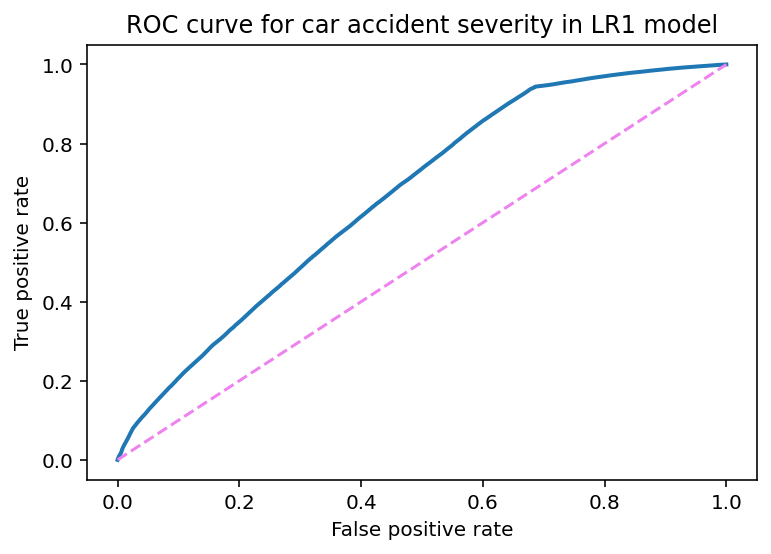

In [14]:
# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_lr1, tpr_lr1, thresholds_lr1 = roc_curve(y_test, predict_prob_lr1[:,1])

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

plt.plot(fpr_lr1, tpr_lr1,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for car accident severity in LR1 model');
# plt.savefig('images/lr1_rocauc.svg', bbox_inches="tight")
print("ROC AUC score for LR1 model = ", roc_auc_score(y_test, predict_prob_lr1[:,1]))

In [15]:
# Precision & Recall at default threshold of 0.5

print("For LR1 model:")
print(f'''    Precision: {round(precision_score(y_test, pred_test_lr1),3)}, 
    Recall: {round(recall_score(y_test, pred_test_lr1),3)}''')

For LR1 model:
    Precision: 0.599, 
    Recall: 0.089


#### Takeaways of LM1 model:
- Traffic Signal seems to be a strong feature.  Interestingly, it's negative, indicating a car accident is more likely to be less severe if there is a traffic signal present.  Perhaps this means that a person is more likely to be caucious/paying attention
- Majority of signs/signals didn't influence model with any significance.  Weather conditions played a bigger role
- Visiblity was removed because did not have that much influence and also there is co-variance risk with it and weather conditions as found in our earlier EDA
- Very minor change of .0001 to F1 score and .00001 to accuracy, but technically did see that adding 'Shut_Down' -- i.e. whether the accident was during the period of stay-at-home orders improved the model.  This starts to provide answers to our greater question around impact of stay-at-home orders on accidents.  

-
### LG2 Model (Logistic Regression w/Undersampling)
Now let's try running the same model as LR1, but with using Undersampling to balance out our classes and see if that helps improve scores >

In [16]:
# create undersampling -- this will give us 408k samples in each class

rus = RandomUnderSampler(random_state=42)

X_train_under, y_train_under = rus.fit_sample(X_train_scaled_v1,y_train)
X_val_under, y_val_under = rus.fit_sample(X_val_scaled_v1,y_val)

In [17]:
# build LM2 model using scaled & undersampled data

LR2 = LogisticRegression(solver='liblinear').fit(X_train_under, y_train_under)

In [18]:
# create predicted values of LR2 model

pred_train_lr2 = LR2.predict(X_train_scaled_v1)
pred_val_lr2 = LR2.predict(X_val_scaled_v1)
pred_test_lr2 = LR2.predict(X_test_scaled_v1)

# create list of predicted probabilities for LR2 model

predict_prob_lr2 = LR2.predict_proba(X_test_scaled_v1)

In [19]:
# validate score/accuracy for the LR2 model

print(f'Training Accuracy Score for LR2: {LR2.score(X_train_scaled_v1, y_train)}')
print(f'Validation Accuracy Score for LR2: {LR2.score(X_val_scaled_v1, y_val)}')
print(f'Test Accuracy Score for LR2: {LR2.score(X_test_scaled_v1, y_test)}')

Training Accuracy Score for LR2: 0.532876293306129
Validation Accuracy Score for LR2: 0.5324573263890584
Test Accuracy Score for LR2: 0.5323681660764535


In [23]:
# f1 score for the LR2 model

print(f'Training F1 Score for LR2: {f1_score(y_train, pred_train_lr2)}')
print(f'Validation F1 Score for LR2: {f1_score(y_val, pred_val_lr2)}')
print(f'Test F1 Score for LR2: {f1_score(y_test, pred_test_lr2)}')

Training F1 Score for LR2: 0.5702734722011216
Validation F1 Score for LR2: 0.5701296544791158
Test F1 Score for LR2: 0.5700070690409668


In [24]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_lr2)

array([[ 91133, 181180],
       [ 10427, 126999]])

In [21]:
# find coefficients for this LR2 model

cofficients_lr2 = dict(zip(X_test_v1.columns, [x for nest in LR2.coef_ for x in nest]))
pd.DataFrame.from_dict(cofficients_lr2, orient='index', columns=['LR2 Model Coefficients'])

,LR2 Model Coefficients
Weather_Condition_Rain/Thunderstorms,0.046999
Sunrise_Sunset,0.073395
Traffic_Signal,-0.673985
Weather_Condition_Snow/Hail,0.044206
Weather_Condition_Foggy/Hazy,-0.032996
Crossing,-0.363922
Temperature(F),0.040927
Shut_Down,-0.042817
Weather_Condition_Clear/Fair,-0.092126
Junction,0.194999


In [22]:
print('INTERCEPT for LR2 Model:')
print(LR2.intercept_)

INTERCEPT for LR2 Model:
[-0.16570569]


#### Takeaways:
- Accuracy of model descreased.  Coefficients are essentially the same -- it's just the intercept that shifted to weight more towards the minority class.  This is not a model we want to move forward with.

-
### LR3 Model (Logistic Regression w/SMOTE)
Now let's try running the same model as LR1, but with using SMOTE to balance out our classes and see if that helps improve scores >

In [25]:
# Create SMOTE sample. This will provide more emphasis 
#    on the regions where the class imbalance is greatest.

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled_v1,y_train)
X_val_smote, y_val_smote = smote.fit_sample(X_val_scaled_v1,y_val)

In [26]:
# build LM3 model using scaled & smote'd data

LR3 = LogisticRegression(solver='liblinear').fit(X_train_smote, y_train_smote)

In [27]:
# create predicted values of LR3 model

pred_train_lr3 = LR3.predict(X_train_scaled_v1)
pred_val_lr3 = LR3.predict(X_val_scaled_v1)
pred_test_lr3 = LR3.predict(X_test_scaled_v1)

# create list of predicted probabilities for LR3 model

predict_prob_lr3 = LR3.predict_proba(X_test_scaled_v1)

In [28]:
# validate score/accuracy for the LR3 model

print(f'Training Accuracy Score for LR3: {LR3.score(X_train_scaled_v1, y_train)}')
print(f'Validation Accuracy Score for LR3: {LR3.score(X_val_scaled_v1, y_val)}')
print(f'Test Accuracy Score for LR3: {LR3.score(X_test_scaled_v1, y_test)}')

Training Accuracy Score for LR3: 0.5324727834209503
Validation Accuracy Score for LR3: 0.5321107634634815
Test Accuracy Score for LR3: 0.5319361837657631


In [29]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_lr3)

array([[ 90819, 181494],
       [ 10290, 127136]])

#### Takeaways:
- Accuracy of model descreased again and results are very similiar to basic undersampling results (LR2 model).  While we do get more correct in minority class, there are more misclassifications (false positive or false negative) then in LR1.

-
### RF1 Model (Random Forest w/all features)
Now we'll test whether using a Random Forest model can improve our model.  We'll begin with using all features.

In [30]:
RF1 = RandomForestClassifier(n_estimators=100)

RF1.fit(X_train_val, y_train_val)

RandomForestClassifier()

In [31]:
# create predicted values of RF1 model

pred_train_RF1 = RF1.predict(X_train_val)
pred_test_RF1 = RF1.predict(X_test)

# create list of predicted probabilities for rf1 model

predict_prob_rf1 = RF1.predict_proba(X_test)

Now look at validation score:

In [32]:
# K-Fold Class Validation Scores

scores_rf1 = cross_val_score(RF1, X_train_val, y_train_val, cv=5, scoring='f1')
print(scores_rf1)
print(round(scores_rf1.mean(),4))

[0.33051798 0.33242269 0.33579739 0.33060357 0.32914539]
0.3317


In [33]:
# find F1 scores for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_RF1, y_train_val)}')
print(f'Test F1 Score: {f1_score(pred_test_RF1, y_test)}')

Training F1 Score: 0.46393703876235076
Test F1 Score: 0.3273414581323463


In [34]:
# find score/accuracy for the RF1 model

print(f'Training Accuracy Score for RF1: {RF1.score(X_train_val, y_train_val)}')
print(f'Test Accuracy Score for RF1: {RF1.score(X_test, y_test)}')

Training Accuracy Score for RF1: 0.7331904778175322
Test Accuracy Score for RF1: 0.6664706068985379


-<br/>
**Confusion Matrix** >

In [35]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_RF1)

array([[239827,  32486],
       [104174,  33252]])

-<br/>
**Feature Importance** >

In [36]:
feat_importance_rf1 = dict(zip(X_test.columns, RF1.feature_importances_))
feat_importance_rf1

{'Temperature(F)': 0.4122813263549539,
 'Visibility(mi)': 0.06310477058365224,
 'Wind_Speed(mph)': 0.1588821737534906,
 'Crossing': 0.06742521838365935,
 'Give_Way': 0.0016382639498472838,
 'Junction': 0.03936022637663859,
 'No_Exit': 0.000698887942303039,
 'Railway': 0.005823028132715471,
 'Station': 0.011254421580219021,
 'Stop': 0.024121338490982518,
 'Traffic_Signal': 0.19441264668581895,
 'Sunrise_Sunset': 0.005927215953934435,
 'Shut_Down': 0.0026219478308569704,
 'Weather_Condition_Clear/Fair': 0.004522674283619757,
 'Weather_Condition_Cloudy': 0.0016421906748762336,
 'Weather_Condition_Dusty': 5.9028776991606524e-05,
 'Weather_Condition_Foggy/Hazy': 0.0007593504362426831,
 'Weather_Condition_Overcast': 0.0010590756210922066,
 'Weather_Condition_Rain/Thunderstorms': 0.002801476954835365,
 'Weather_Condition_Smoke': 0.00022034317132195243,
 'Weather_Condition_Snow/Hail': 0.0012416992166434625,
 'Weather_Condition_Wintry Mix': 0.00014269484530450173}

#### Takeaways:
- Seeing nice improvement in F1 score.  
- Training and test scores have enough separation that there is likely some overfitting going on.  If decide to continue with this model, will do a GridSearchCV to refine model.
- Dusty Weather appears to have a strong feature importance -- a feature that had minimal to no effect on the Logistic Regression models (returned to them to test and verified this)

-
### RF2 Model (Random Forest w/narrowed features)
For some comparison and to see if can help with overfitting, we'll try a version of Random Forest with narrowed features to see if that helps performance.

In [37]:
#create new X set of v1 features for combined train & validation sets
X_train_val_v1 = X_train_val[v1_features]

In [38]:
RF2 = RandomForestClassifier(n_estimators=100)

RF2.fit(X_train_val_v1, y_train_val)

RandomForestClassifier()

In [39]:
# create predicted values of RF2 model

pred_train_RF2 = RF2.predict(X_train_val_v1)
pred_test_RF2 = RF2.predict(X_test_v1)

# create list of predicted probabilities for RF2 model

predict_prob_rf2 = RF2.predict_proba(X_test_v1)

In [40]:
# K-Fold Class Validation Scores

scores_rf2 = cross_val_score(RF2, X_train_val_v1, y_train_val, cv=5, scoring='f1')
print(scores_rf2)
print(round(scores_rf2.mean(),4))

[0.1937117  0.19965895 0.19690881 0.19225012 0.19683261]
0.1959


In [41]:
# find F1 scores for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_RF2, y_train_val)}')
print(f'Test F1 Score: {f1_score(pred_test_RF2, y_test)}')

Training F1 Score: 0.20428206936419682
Test F1 Score: 0.19264717447987562


#### Takeaways:
   -  Significant dips on scores with the reduction of features.  Will return to RF1 to refine that model if needed.

-
## 2020-Only Modeling
To see if being in shut down plays a bigger role in predicting accidents in 2020 alone, we'll follow our exact method for the LM1 model, but only use 2020 samples. >

In [89]:
# create new dataframe with only 2020 samples

model_2020 = model_data2[model_data2.Year == 2020]

model_2020.shape

(204916, 24)

With our filtered data using only 2020 samples we see we have ~205k samples.

Now we'll create new training and test sets and run exactly as we did the LM1 model. >

In [90]:
X_2020 = model_2020.drop(columns='Severity')
y_2020 = model_2020['Severity']

In [91]:
X_train_val_2020, X_test_2020, y_train_val_2020, y_test_2020 = train_test_split(
    X_2020, y_2020, test_size=0.2, random_state=42, stratify = y_2020)

In [92]:
X_train_2020, X_val_2020, y_train_2020, y_val_2020 = train_test_split(X_train_val_2020,
                                                                      y_train_val_2020,
                                                                      test_size=.25,
                                                                      random_state=42,
                                                                      stratify = y_train_val_2020
                                                                     )

In [103]:
std_scale = StandardScaler()

#features we want to use for this model (and used for LM1)
v1_features = ['Weather_Condition_Rain/Thunderstorms', 'Sunrise_Sunset',
               'Traffic_Signal','Weather_Condition_Snow/Hail',
               'Weather_Condition_Foggy/Hazy','Shut_Down',
               'Crossing','Temperature(F)',
               'Weather_Condition_Clear/Fair',
               'Junction'
              ]

#create new X set of v1 features for training and test set
X_train_v1_2020 = X_train_2020[v1_features]
X_val_v1_2020 = X_val_2020[v1_features]
X_test_v1_2020 = X_test_2020[v1_features]

# scale all of the features for training and test set
X_train_scaled_v1_2020 = std_scale.fit_transform(X_train_v1_2020)
X_val_scaled_v1_2020 = std_scale.fit_transform(X_val_v1_2020)
X_test_scaled_v1_2020 = std_scale.fit_transform(X_test_v1_2020)

# create training model using scaled features
LR1_2020 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v1_2020, y_train_2020)

In [104]:
# create predicted values of LR1_2020 model

pred_train_lr1_2020 = LR1_2020.predict(X_train_scaled_v1_2020)
pred_val_lr1_2020 = LR1_2020.predict(X_val_scaled_v1_2020)
pred_test_lr1_2020 = LR1_2020.predict(X_test_scaled_v1_2020)

# create list of predicted probabilities for LR1_2020 model

predict_prob_lr1_2020 = LR1_2020.predict_proba(X_test_scaled_v1_2020)

In [105]:
# validate score/accuracy for the LR1_2020 model

print(f'Training Accuracy Score for LR1_2020: {LR1_2020.score(X_train_scaled_v1_2020, y_train_2020)}')
print(f'Validation Accuracy Score for LR1_2020: {LR1_2020.score(X_val_scaled_v1_2020, y_val_2020)}')
print(f'Test Accuracy Score for LR1_2020: {LR1_2020.score(X_test_scaled_v1_2020, y_test_2020)}')

Training Accuracy Score for LR1_2020: 0.7152071183986857
Validation Accuracy Score for LR1_2020: 0.7160529975843642
Test Accuracy Score for LR1_2020: 0.7162063244192856


In [106]:
# f1 score for the LR1 model

print(f'Training F1 Score for LR1_2020: {f1_score(y_train_2020, pred_train_lr1_2020)}')
print(f'Validation F1 Score for LR1_2020: {f1_score(y_val_2020, pred_val_lr1_2020)}')
print(f'Test F1 Score for LR1_2020: {f1_score(y_test_2020, pred_test_lr1_2020)}')

Training F1 Score for LR1_2020: 0.1020643672265675
Validation F1 Score for LR1_2020: 0.1022911363110391
Test F1 Score for LR1_2020: 0.10358381502890172


In [97]:
# create simple confusion matrix

confusion_matrix(y_test_2020, pred_test_lr1_2020)

array([[28681,   495],
       [11136,   672]])

In [98]:
# find coefficients for this LR1 model

cofficients_lr1_2020 = dict(zip(X_test_v1_2020.columns, [x for nest in LR1_2020.coef_ for x in nest]))
pd.DataFrame.from_dict(cofficients_lr1_2020, orient='index', columns=['LR1_2020 Model Coefficients'])

,LR1_2020 Model Coefficients
Weather_Condition_Rain/Thunderstorms,0.092506
Sunrise_Sunset,0.056153
Traffic_Signal,-0.689134
Weather_Condition_Snow/Hail,0.036773
Weather_Condition_Foggy/Hazy,-0.059922
Shut_Down,-0.048553
Crossing,-0.344948
Temperature(F),0.064435
Weather_Condition_Clear/Fair,-0.097388
Junction,0.158766
